In [4]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from IPython.display import display # Needed to display dfs when temporarily expanding print limits
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
pd.set_option('display.float_format', lambda x: '%.5f' % x) # supress scientific notation

# Load in data & high level look

In [5]:
# Read in desired listings data
cities_of_interest = ['Los Angeles'] # Cities to read from dataset
listings_parquet = pq.ParquetDataset('./Data/listings',
                                     filters=[('Country_City', 'in', cities_of_interest)],
                                     use_legacy_dataset=False)
listings = listings_parquet.read().to_pandas() # Convert to dataframe
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Country_City,Data Date
0,109,https://www.airbnb.com/rooms/109,20220308023311,2022-03-08,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,...,4.00000,None,f,1,1,0,0,0.02000,Los Angeles,"08 March, 2022"
1,2732,https://www.airbnb.com/rooms/2732,20220308023311,2022-03-09,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,...,4.43000,228269,f,2,1,1,0,0.17000,Los Angeles,"08 March, 2022"
2,2864,https://www.airbnb.com/rooms/2864,20220308023311,2022-03-30,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,https://www.airbnb.com/users/show/3207,...,NaN,None,f,1,1,0,0,NaN,Los Angeles,"08 March, 2022"
3,3021,https://www.airbnb.com/rooms/3021,20220308023311,2022-03-08,Hollywood Hills Zen Modern style Apt/Guesthouse,A very Modern Hollywood Hills Zen style galler...,This is the famous Hollywood hills.. Historica...,https://a0.muscache.com/pictures/5147dcd2-efad...,3415,https://www.airbnb.com/users/show/3415,...,4.00000,None,f,4,1,3,0,0.22000,Los Angeles,"08 March, 2022"
4,5728,https://www.airbnb.com/rooms/5728,20220308023311,2022-03-08,Tiny Home in Artistic Oasis near Venice and LAX,Our home is located near Venice Beach without ...,Our neighborhood is very quiet and save. There...,https://a0.muscache.com/pictures/7a29d275-f293...,9171,https://www.airbnb.com/users/show/9171,...,4.70000,HSR19-002149,f,4,1,3,0,2.03000,Los Angeles,"08 March, 2022"


In [6]:
# Get Dataframe info - number of non-nulls in each column, data types
listings_info = pd.DataFrame(listings.dtypes, index=listings.columns, columns=['dtype'])
listings_info['Non-Null Count'] = listings.count()
listings_info['Unique Values'] = listings.nunique()
with pd.option_context('display.max_rows', None, 'display.width', 1000):
    print(listings_info)

                                                 dtype  Non-Null Count  Unique Values
id                                               int64           33629          33629
listing_url                                     object           33629          33629
scrape_id                                        int64           33629              1
last_scraped                                    object           33629              5
name                                            object           33627          32332
description                                     object           32717          30110
neighborhood_overview                           object           20251          16834
picture_url                                     object           33629          32090
host_id                                          int64           33629          18324
host_url                                        object           33629          18324
host_name                                       object

In [7]:
# Remove columns that we know aren't needed
# Includes url parameters, id parameters, data scrape columns, and columns with limited/no data
# Note: Will also ignore name/description for now as these are highly variable text fields
unneeded_cols = ['Data Date', 'name', 'description', 'Country_City', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_url', 
                'host_thumbnail_url', 'host_picture_url', 'bathrooms', 'calendar_updated', 'calendar_last_scraped']
print(listings.shape)
listings.drop(columns=unneeded_cols, errors='ignore', inplace=True)
print(listings.shape)

(33629, 76)
(33629, 62)


# Numeric Data

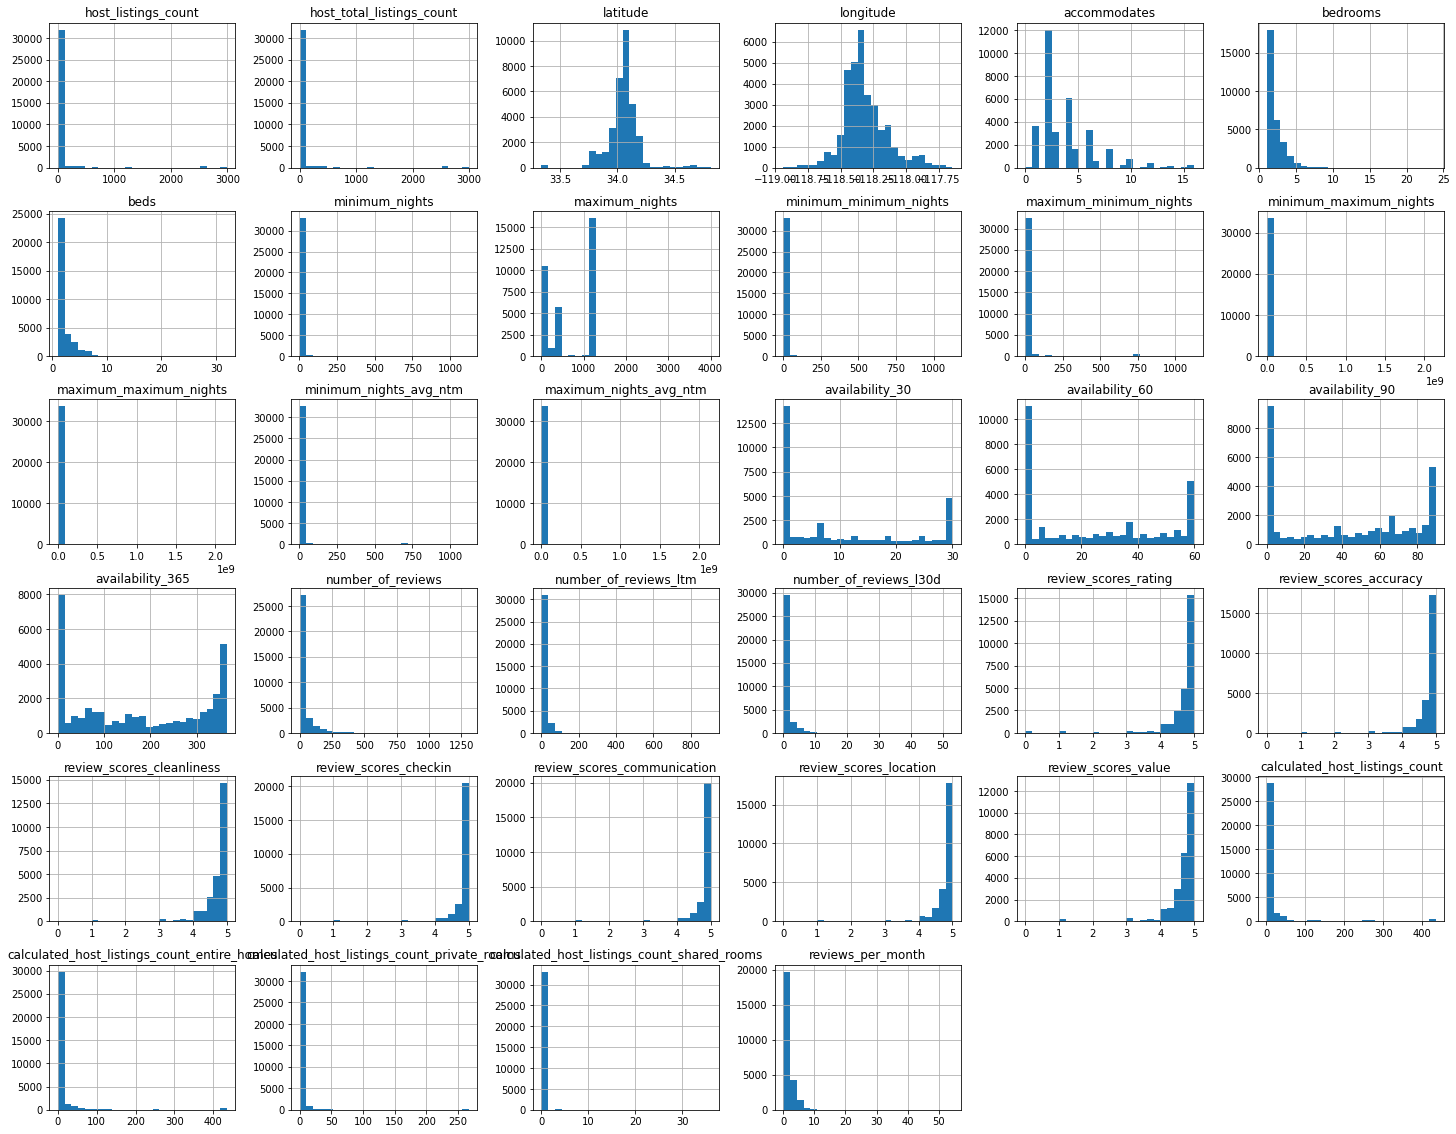

In [8]:
# Plot histogram of numeric variables
listings['price'] = listings['price'].str.replace(r'\$|\,', '', regex=True).astype(float) # Convert target to float
ignore_cols = ['id', 'host_id', 'price'] # Columns we don't need in histogram
hist_cols = [c for c in listings.columns if c not in ignore_cols and is_numeric_dtype(listings[c])] # Columns to view histogram for
listings.loc[:, hist_cols].hist(bins=25, figsize=(25,20));

In [9]:
# Get IQR range bounds for data to determine outliers
listing_stats = listings[hist_cols].describe()
IQR = listing_stats.loc['75%'] - listing_stats.loc['25%']
listing_stats.loc['IQRMin'] = listing_stats.loc['25%'] - 1.5 * IQR
listing_stats.loc['IQRMax'] = listing_stats.loc['75%'] + 1.5 * IQR
listing_stats.loc['Range'] = listing_stats.loc['max'] - listing_stats.loc['min']

# Get the number of outliers in each column
cols = listing_stats.columns
outliers = np.empty((len(listing_stats.columns),))
for idx, c in enumerate(cols):
    iqr_min = listing_stats.loc['IQRMin', c]
    iqr_max = listing_stats.loc['IQRMax', c]
    col_data = listings[c].to_numpy()
    outliers[idx] = np.count_nonzero((col_data < iqr_min) | (col_data > iqr_max))
listing_stats.loc['NumOutliers'] = outliers

# Print Results
with pd.option_context('display.max_rows', None, 'display.width', 1000):
    display(listing_stats.T)

,count,mean,std,min,25%,50%,75%,max,IQRMin,IQRMax,Range,NumOutliers
host_listings_count,33625.00000,56.93178,311.85553,0.00000,1.00000,2.00000,8.00000,2992.00000,-9.50000,18.50000,2992.00000,5205.00000
host_total_listings_count,33625.00000,56.93178,311.85553,0.00000,1.00000,2.00000,8.00000,2992.00000,-9.50000,18.50000,2992.00000,5205.00000
latitude,33629.00000,34.05028,0.13626,33.33848,33.99584,34.06033,34.10610,34.81326,33.83045,34.27149,1.47478,2780.00000
longitude,33629.00000,-118.31838,0.16900,-118.94061,-118.42099,-118.34476,-118.25005,-117.64673,-118.67740,-117.99364,1.29388,2223.00000
accommodates,33629.00000,3.74156,2.63784,0.00000,2.00000,3.00000,5.00000,16.00000,-2.50000,9.50000,16.00000,1545.00000
bedrooms,30029.00000,1.72280,1.14391,1.00000,1.00000,1.00000,2.00000,24.00000,-0.50000,3.50000,23.00000,2439.00000
beds,32917.00000,2.07495,1.53657,1.00000,1.00000,2.00000,3.00000,32.00000,-2.00000,6.00000,31.00000,574.00000
minimum_nights,33629.00000,19.47462,33.18510,1.00000,2.00000,30.00000,30.00000,1124.00000,-40.00000,72.00000,1123.00000,405.00000
maximum_nights,33629.00000,629.43587,493.52270,1.00000,90.00000,365.00000,1125.00000,4000.00000,-1462.50000,2677.50000,3999.00000,5.00000
minimum_minimum_nights,33624.00000,19.71181,36.86534,1.00000,2.00000,30.00000,30.00000,1124.00000,-40.00000,72.00000,1123.00000,414.00000


### Observations:
* A number of outliers in the minimum/maximum night columns
    * These can be ignored if the feature is being used
        * Not sure yet if it makes sense to throw out the entire row or fill with a different value
        * A lot of these look like typos as well
    * Average minimum/maximum night columns look better, though it looks like the outlier values are impacting those as well
* How should availability be handled?
    * Represents the number of days a property is available in that timeframe
    * 0 would indicate that there is no upcoming availability
    * Reduction of availability could be from a number of things
        * Part time host, always booked, etc.
    * Likely need to consider it in combination with other features like reivew counts, number of recent review, etc.
* A fair number of skewed distributions, should see if log distributions look better

In [10]:
# Let's look at outliers for the maximum_nights_avg
# Can definitely see there was a calculation error or typo
# Base minimum/maximum nights data looks good, might work with those to begin with
listings[hist_cols].sort_values(by=['minimum_maximum_nights'], ascending=False).head(8).T

,19041,16816,19042,1359,2045,184,582,10444
host_listings_count,3.00000,3.00000,3.00000,1.00000,1.00000,5.00000,3.00000,2.00000
host_total_listings_count,3.00000,3.00000,3.00000,1.00000,1.00000,5.00000,3.00000,2.00000
latitude,34.03972,34.03972,34.03972,33.76813,33.83296,34.03862,34.08044,34.00673
longitude,-118.25852,-118.25852,-118.25852,-118.18359,-118.38597,-118.62243,-118.36695,-117.78758
accommodates,2.00000,2.00000,2.00000,4.00000,2.00000,6.00000,2.00000,2.00000
bedrooms,1.00000,1.00000,1.00000,NaN,1.00000,3.00000,1.00000,1.00000
beds,1.00000,1.00000,2.00000,2.00000,1.00000,4.00000,1.00000,1.00000
minimum_nights,1.00000,1.00000,1.00000,7.00000,30.00000,2.00000,30.00000,100.00000
maximum_nights,1125.00000,1125.00000,1125.00000,4000.00000,3650.00000,3022.00000,3000.00000,3000.00000
minimum_minimum_nights,1.00000,1.00000,1.00000,7.00000,30.00000,2.00000,30.00000,100.00000


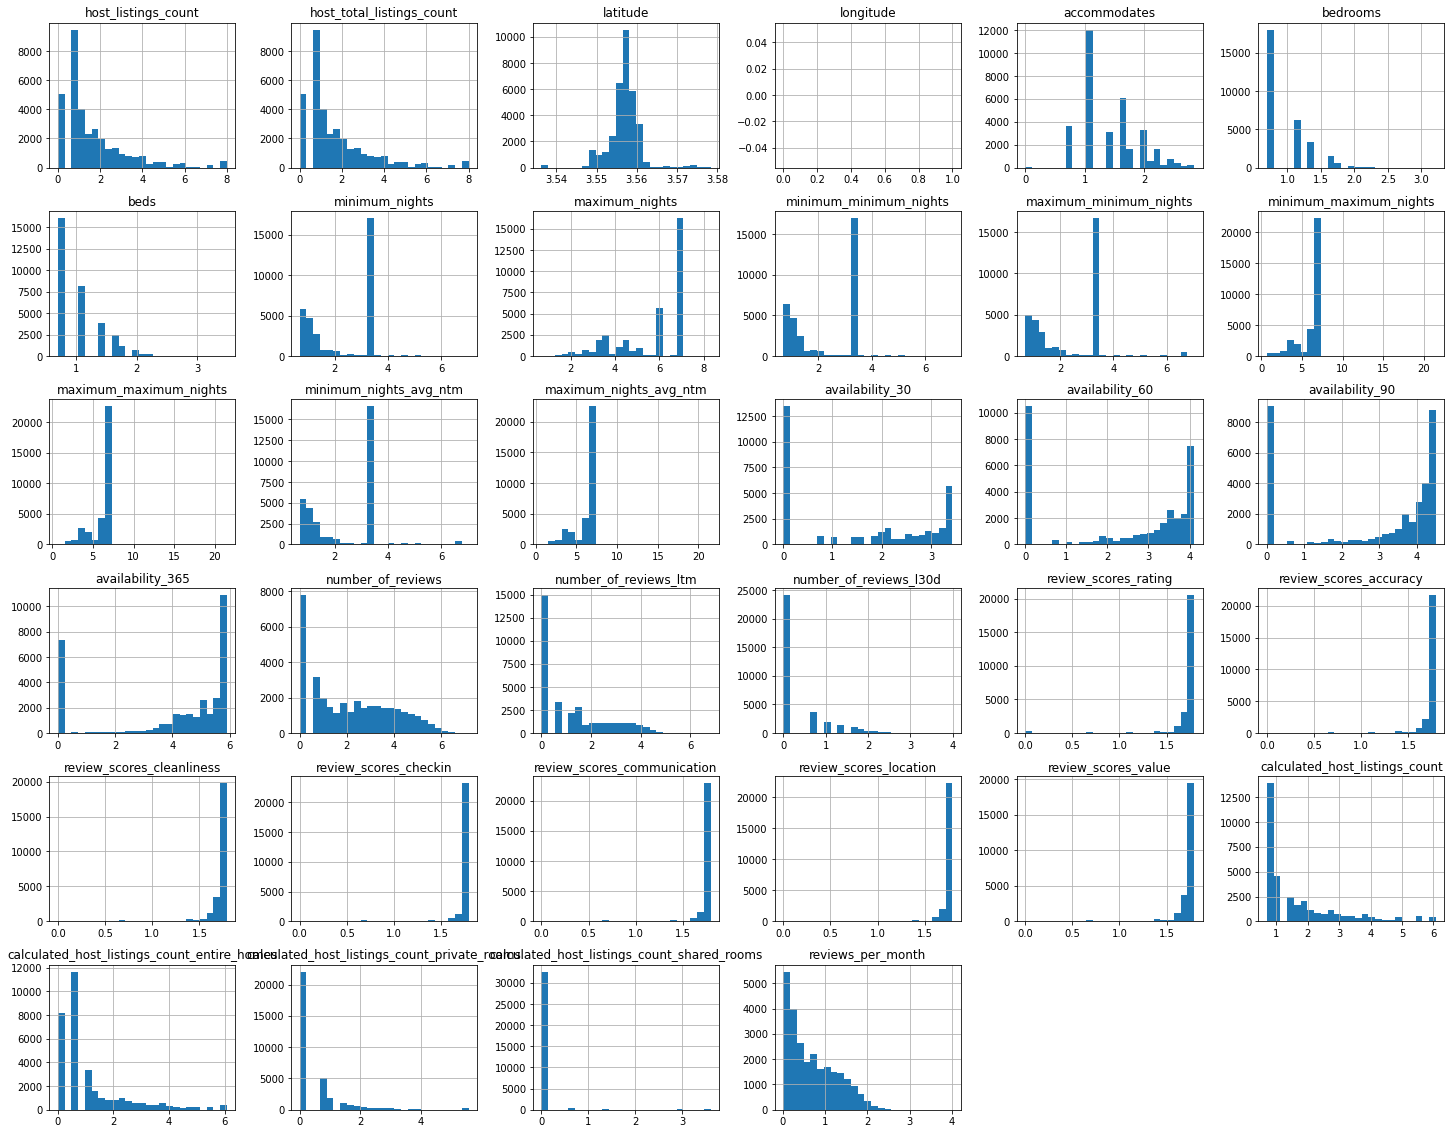

In [16]:
# Let's take a look at the log distributions for the numeric features
log_listings = np.log(listings[hist_cols] + 1) # log(x + 1) to avoid zero values
log_listings.hist(bins=25, figsize=(25,20));